# Deflection-Profile Validation

In [1]:
%matplotlib widget
# %matplotlib qt
from bmcs_cross_section.api import MKappa, TShape, MKappaParamsStudy, EC2, ReinfLayer, IShape, CustomShape
from bmcs_beam.api import BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [4]:
bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

#def plot(mc):
#     fig, ax = plt.subplots(1, 1)
#     dp = DeflectionProfile(mc=mc)
#     F, w = dp.get_Fw()
#     ax.plot(w, F / 1000, c= 'blue', label= 'bmcs_deflection'); ax.legend()
#     ax.set_xlabel(r'$w$ [mm]')
#     ax.set_ylabel(r'$F$ [kN]')
#     plt.show()

def plot_fw_ver(mc, ver_data, data, L, mode, f_coef):
    
    # mode: 'multi' to plot multiple experiments and 'one' to plot one experiment
    # f_coef: a coeficient for the 'F' values of the experiment based on the experiment configuration;
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    dp.mc.plot_mk(ax1)
    dp.plot_fw(ax2)
    if mode == 'multi':
        for i in range(0,data.shape[1],2):
            ax2.plot(data.iloc[:, i+1],data.iloc[:, i] * f_coef, label = data.columns.tolist()[i][0:-2] , alpha=0.5)
        ax2.plot([L/250 , L/250], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(data.iloc[:, 2]) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(data.iloc[:, 2]) * f_coef))
    
    else:
        w = ver_data[0]
        f = ver_data[1]
        ax2.plot(w, f * f_coef, c= 'red', label= 'Experiment')
        ax2.plot([L/250 , L/250], [0, max(f) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(f) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(f) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(f) * f_coef))
    ax2.legend()
    
    return fig

def plot_fw_ver(dp, ver_data, test_name='', title=None, ax=None, color_i=0): # ax, dp, ver_data
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    dp.plot_fw(ax, dashed=True, color=plot_colors[color_i])
    ax.plot(ver_data[1], ver_data[0], c=plot_colors[color_i], label= 'Exp. (' + test_name + ')')
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Deflection [mm]')
    ax.set_ylabel('Load [kN]')
    ax.legend()
    if 'fig' in locals():
        return fig, ax
    
def interact(dp):
    dp.interact()

def make_mc(form='rectangular', B=200, H=200, 
            material_r1='steel', E_r1=200000, high_kappa = 0.00005,
            f_cm=40, matrix = 'EC2', eps_cr = None, eps_cy=None, eps_cu=None, eps_tu=None, mu=None, E_cc=None, E_ct=None,
            f_ctm=None,
            z_r1=10,
            A_r1=100,
            f_t_r1=None,
            f_sy_r1=500,
            f_st_r1=None,
            eps_ud_r1=0.025,
            material_r2=None, 
            z_r2=None, 
            A_r2=None,
            E_r2=None,
            f_t_r2=None,
            f_sy_r2=None,
            f_st_r2=None,
            eps_ud_r2=0.025,
            n_kappa=200, n_m = 200, slider=None):
    
    mc = MKappa(low_kappa=0, 
                high_kappa=high_kappa,
                n_m=n_m,
                n_kappa=n_kappa)
    
    mc.cs_design.matrix = matrix
    if slider is not None:
        mc.kappa_slider = slider
    
    if form=='rectangular':
        mc.cross_section_shape_.B = B
        mc.cross_section_shape_.H = H
    
    if matrix == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
        eps_cy = eps_cy,
        eps_cu = eps_cu,
    )
    else:
        mc.cs_design.matrix_.f_cm=f_cm
        
    if eps_tu is not None:
        mc.cs_design.matrix_.eps_tu = eps_tu
    if eps_cr is not None:
        mc.cs_design.matrix_.eps_cr = eps_cr
    if mu is not None:
        mc.cs_design.matrix_.mu = mu
    if E_cc is not None:
        mc.cs_design.matrix_.E_cc = E_cc
    if E_ct is not None:
        mc.cs_design.matrix_.E_ct = E_ct
    
    bl1 = ReinfLayer(name='layer1', z=z_r1, A=A_r1, matmod=material_r1)
    if material_r1 == 'carbon':
        bl1.matmod_.trait_set(E=E_r1,f_t=f_t_r1)
    if material_r1 == 'steel':
        bl1.matmod_.trait_set(E_s=E_r1, f_sy=f_sy_r1, eps_ud = eps_ud_r1, f_st=1.05*f_sy_r1 if f_st_r1 is None else f_st_r1)
    mc.cross_section_layout.add_layer(bl1)
    
    if material_r2 is not None:
        bl2 = ReinfLayer(name='layer2', z=z_r2, A=A_r2, matmod=material_r2)
        if material_r2 == 'carbon':
            bl2.matmod_.trait_set(E=E_r2,f_t=f_t_r2)
        if material_r2 == 'steel':
            bl2.matmod_.trait_set(E_s=E_r2, f_sy=f_sy_r2, eps_ud = eps_ud_r2, f_st=1.05*f_sy_r2 if f_st_r2 is None else f_st_r2)
        mc.cross_section_layout.add_layer(bl2)
    
    return mc

def get_dp(mc, system, L, L_F):
    dp = DeflectionProfile(mc=mc)
    dp.beam_design.system = system
    dp.beam_design.system_.L = L
    dp.beam_design.system_.L_F = L_F
    return dp
    
    
def make_simulation(high_kappa,E,f_cm,mu,B,H,material,E_reinforcement,system,L,L_F,
                    z=False,alpha=False,A=False,rho=False,f_t=False,f_sy=False,f_ctm=False,eps_cr=False,beta_tu=False):

    if z==False:
        z=H * (1 - alpha)
        print('z= '+str(z))
    if A==False:
        A=A=rho * B * alpha * H
        print('A= '+str(A))
    if eps_cr==False:
        eps_cr=f_ctm/E
        print('eps_cr= '+str(eps_cr))
    if beta_tu==False:
        eps_tu = f_ctm/E
        print('eps_tu= '+str(eps_tu))
    else:
        eps_tu = beta_tu * eps_cr
        print('eps_tu= '+str(eps_tu))

    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa)
    mc.cs_design.matrix='EC2'
    mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=f_ctm/E,
        eps_tu=f_ctm/E,
        mu=0.0,
        f_cm = f_cm
    )
    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H
        
    bl1 = ReinfLayer(name=material, z=z, A=A, matmod=material)
    if material == 'carbon':
        bl1.matmod_.trait_set(E=E_reinforcement,f_t=f_t,factor = 1.)
    if material == 'steel':
        bl1.matmod_.trait_set(E_s=E_reinforcement, f_sy=f_sy)
    mc.cross_section_layout.add_layer(bl1)
    
    dp = DeflectionProfile(mc=mc)
    dp.beam_design.system = system
    dp.beam_design.system_.L = L
    dp.beam_design.system_.L_F = L_F
    
    return dp
    
def get_data_ghadioui():
    excel_file = join('verification_data', 'el_ghadioui2020', 'fig_3.xlsx')
    data = pd.read_excel(excel_file, engine='openpyxl')
    
    return data

def get_data(element1, xlsx_file, u, f, element2=False, u_faktor=False):
    if element2 == False:
        excel_file = join(element1, xlsx_file)
    else: excel_file = join(element1, element2, xlsx_file)
    data = pd.read_excel(excel_file, engine='openpyxl')
    if(u_faktor==False):
        u_faktor = 1
    u = data[u]*u_faktor
    f = data[f]
    ver_data = [f, u]
    
    return ver_data

## Validation with experimental results

## Rectangluar cross sections

### El Ghadioui2020 (Steel, CFRP)
https://link.springer.com/article/10.1617/s11527-020-01496-7

eps_cr= 0.00011455409817286213
eps_tu= 0.00011455409817286213


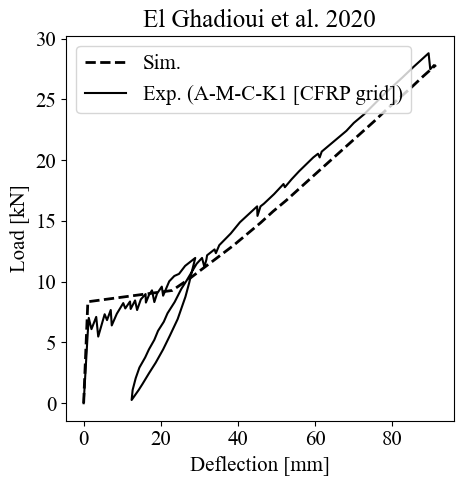

In [8]:
# Beam A-M-C-K1 - Grid (C 40/50)
# Adapted params in comparison to the paper: None

data = get_data_ghadioui()
ver_data = [data['A-M-C-K1_load'], data['A-M-C-K1_deflection']]

dp = make_simulation(high_kappa=0.00021,
                     E=34918,
                     f_cm=52.9,
                     f_ctm=4,
                     mu=0.0,
                     B=500,
                     H=105,
                     material='carbon',
                     z=21,
                     A=13*8.16,
                     E_reinforcement=108606,
                     f_t=1429,
                     system='4pb',
                     L=2200,
                     L_F=870)
fig, ax = plot_fw_ver(dp, ver_data, r'A-M-C-K1 [CFRP grid]', title='El Ghadioui et al. 2020', color_i=0)
fig

In [ ]:
# Beam A-M-C-K2 - Grid (C 40/50)
# Adapted params in comparison to the paper: None

data = get_data_ghadioui()
ver_data = [data['A-M-C-K2_load'], data['A-M-C-K2_deflection']]

dp = make_simulation(high_kappa=0.00021,
                     E=34918,
                     f_cm=52.9,
                     f_ctm=4,
                     mu=0.0,
                     B=500,
                     H=105,
                     material='carbon',
                     z=17,
                     A=13*8.16,
                     E_reinforcement=108606,
                     f_t=1429,
                     system='4pb',
                     L=2200,
                     L_F=870)

plot_fw_ver(dp, ver_data, r'A-M-C-K2 [CFRP grid]', ax=ax, color_i=1)
fig

In [ ]:
# fig.savefig('LD_El Ghadioui_A-M-C-K1_A-M-C-K2.pdf')

### Yang et al. (2010) (FRC with steel reinforcement)
http://dx.doi.org/10.1016/j.engstruct.2010.07.017

In [ ]:
# R14-2 (rho = 1.2%)
# Adapted params in comparison to the paper: eps_cr, eps_tu, mu, f_sy (f_sy not mentioned, the others were calibrated)

ver_data = get_data(element1='./verification_data/Yang2010', xlsx_file='yang2010.xlsx', u='R14-2_deflection', f='R14-2_load')

mc = make_mc(
            form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=45530, E_ct=45530,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 196.1/45530,
            eps_cu = EC2.get_eps_cu3(196.2-8),
            material_r1='steel', z_r1=35, A_r1=506.8, E_r1=200000, f_sy_r1=600,
            )
dp = get_dp(mc=mc, system='4pb', L=2700, L_F=1130)

fig, ax = plot_fw_ver(dp, ver_data, r'R14-2, $V_\mathrm{f}$ = 2%, $\rho$ = 1.2%', title='Yang et al. 2010', color_i=0)
fig
# dp.interact()

In [ ]:
# R13-2 (rho = 0.9%)
ver_data = get_data(element1='./verification_data/Yang2010', xlsx_file='yang2010.xlsx', u='R13-2_deflection', f='R13-2_load')
mc = make_mc(form='rectangular', high_kappa=0.00005, B=180, H=270,
            matrix='piecewise linear',
            E_cc=46680, E_ct=46680,
            mu=0.55,
            eps_cr=0.000384,
            eps_tu = 24 * 0.000384,
            eps_cy = 192.2/46680,
            eps_cu = EC2.get_eps_cu3(192.2-8),
            material_r1='steel', z_r1=35, A_r1=380.1, E_r1=200000, f_sy_r1=600,
            )
dp = get_dp(mc=mc, system='4pb', L=2700, L_F=1130)

plot_fw_ver(dp, ver_data, r'R13-2, $V_\mathrm{f}$ = 2%, $\rho$ = 0.9%', ax=ax, color_i=1)
fig
# dp.interact()

In [ ]:
# fig.savefig('LD_Yang_R13-2_R14-2.pdf')

###  Almusallam1997 (Steel, GFRP) https://journals.sagepub.com/doi/pdf/10.1177/002199839703100701

In [ ]:
# Group 1 (Steel):
ver_data = get_data(element1='./verification_data/', xlsx_file='Almusallam1997.xlsx', 
                    u='group_1_deflection', f='group_1_load')
mc = make_mc(form='rectangular', high_kappa=0.000065, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='steel',
             material_r2 = 'steel',
             A_r1 = 3*np.pi*7**2, E_r1 = 200000, z_r1=50, f_sy_r1=553,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
dp = get_dp(mc=mc, system='4pb', L=2700, L_F=1250)
dp. n_load_steps = 101

fig, ax = plot_fw_ver(dp, ver_data, r'Group 1 - Steel', title='Almusallam 1997', color_i=0)
fig
# dp.interact()

In [ ]:
# Group 2 (GFRP):
ver_data = get_data(element1='./verification_data/', xlsx_file='Almusallam1997.xlsx', 
                    u='group_2_deflection', f='group_2_load')
mc = make_mc(form='rectangular', high_kappa=0.000066, B=200, H=210,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(19/2)**2, E_r1 = 35630, z_r1=210-158, f_t_r1=700,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
dp = get_dp(mc=mc, system='4pb', L=2700, L_F=1250)
dp. n_load_steps = 101

plot_fw_ver(dp, ver_data, r'Group 2 - GFRP', ax=ax, color_i=1)
fig
# dp.interact()

In [ ]:
# Group 3 (GFRP):
ver_data = get_data(element1='./verification_data/', xlsx_file='Almusallam1997.xlsx', 
                    u='group_3_deflection', f='group_3_load')
mc = make_mc(form='rectangular', high_kappa=0.00007, B=200, H=260,
             eps_cy=None, eps_cu=None, eps_tu=None,
             f_cm=31.3,
            material_r1='carbon',
             material_r2 = 'steel',
             A_r1 = 4*np.pi*(12.7/2)**2, E_r1 = 43370, z_r1=260-211, f_t_r1=886,
             A_r2 = 1*np.pi*(6.25/2)**2,  E_r2 = 200000, z_r2=210-50, f_sy_r2=553
            )
dp = get_dp(mc=mc, system='4pb', L=2700, L_F=1250)
dp. n_load_steps = 101

plot_fw_ver(dp, ver_data, r'Group 3 - GFRP', ax=ax, color_i=2)
fig
# dp.interact()

In [ ]:
# fig.savefig('LD_Almusallam1997.pdf')

### Hong et al. 2011 (Rect. CS, Hybrid steel + CFRP)
https://academicjournals.org/journal/IJPS/article-full-text-pdf/CADD4B225208

In [ ]:
f_sy = (533 + 525 + 528 + 512)/4
f_st = (615 + 628 + 631 + 629)/4
eps_ud = 0.01 * (17.1 + 18.5 + 16.6 + 16.3)/4

def get_hong_dp(rho_s, cfrp_num=2, f_cm=27, b=250, h=400):
    d_s = 15.9
    d = h - 30 - 9.53 - d_s/2
    mc = make_mc(form='rectangular', high_kappa=0.00007, B=b, H=h,
                 eps_cy=None, eps_cu=None, eps_tu=None,
                 f_cm=f_cm,
                 material_r1='steel',
                 material_r2='steel',
                 A_r1 = rho_s * b * d,  E_r1 = 200000, z_r1 = h - d , f_sy_r1=f_sy, f_st_r1=f_st, eps_ud_r1=eps_ud,
                 A_r2 = 2*np.pi*(9.53/2)**2,  E_r2 = 200000, z_r2 = d , f_sy_r2=f_sy, f_st_r2=f_st, eps_ud_r2=eps_ud,
                )
    if cfrp_num > 0:
        rl = ReinfLayer(z = 7.5, A = cfrp_num * 2.8 * 10, matmod='carbon')
        rl.matmod_.trait_set(E = 165000, f_t = 2850)
        mc.cross_section_layout.add_layer(rl)

    dp = get_dp(mc=mc, system='4pb', L=3600, L_F=1500)
    dp.n_load_steps = 100
    return dp

In [ ]:
# Beam BMIV:
ver_data = get_data(element1='./verification_data', xlsx_file='Hong2011.xlsx', 
                    u='BMIV_deflection', f='BMIV_load')
dp = get_hong_dp(0.0142, 0, f_cm=34, b=400, h=200)

fig, ax = plot_fw_ver(dp, ver_data, r'BMIV - Steel', title='Hong et al. 2011', color_i=0)
# plot_fw_ver(dp, ver_data, r'BMIV - Steel', ax=ax, color_i=0)

fig
# dp.interact()

In [ ]:
# Beam BMIV-1:
ver_data = get_data(element1='./verification_data', xlsx_file='Hong2011.xlsx', 
                    u='BMIV-1_deflection', f='BMIV-1_load')
dp = get_hong_dp(0.0142, 1, f_cm=34, b=400, h=200)

plot_fw_ver(dp, ver_data, r'BMIV-1 - Carbon + Steel', ax=ax, color_i=1)
fig
# dp.interact()

In [ ]:
# Beam BMIV-3:
ver_data = get_data(element1='./verification_data', xlsx_file='Hong2011.xlsx', 
                    u='BMIV-3_deflection', f='BMIV-3_load')
dp = get_hong_dp(0.0142, 3, f_cm=34, b=400, h=200)

plot_fw_ver(dp, ver_data, r'BMIV-3 - Carbon + Steel', ax=ax, color_i=2)
fig
# dp.interact()